In [58]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

plt.rcParams['font.size'] = 10

In [59]:
df_multi_label = pd.read_csv("multi_label_jaccard.csv", 
                        quoting=csv.QUOTE_ALL,      # 处理所有引号
                        doublequote=True,           # 处理双引号
                        skipinitialspace=True)
df_multi_label.columns = df_multi_label.columns.str.strip().str.replace(' ', '_')

In [60]:
df_multi_class = pd.read_csv("multi_class_log_results.csv", 
                        quoting=csv.QUOTE_ALL,      # 处理所有引号
                        doublequote=True,           # 处理双引号
                        skipinitialspace=True)
df_multi_class.columns = df_multi_class.columns.str.strip().str.replace(' ', '_')
df_multi_class['task_type'] = 'multi_class'

In [61]:
# 合并 df_multi_label 和 df_multi_class
df_combined = pd.concat([df_multi_label, df_multi_class], axis=0, join='inner', ignore_index=True)

# 重置索引
df_combined = df_combined.reset_index(drop=True)

# 验证合并结果
print("Combined DataFrame shape:", df_combined.shape)

# 验证是否包含两种类型的数据
print("\nVerification of data sources:")
print(df_combined.groupby(['task_type'])['target_val_acc'].count())

Combined DataFrame shape: (3240, 42)

Verification of data sources:
task_type
multi_class    1620
multi_label    1620
Name: target_val_acc, dtype: int64


In [62]:
# 获取所有字符串(object)类型的列
string_columns = df_combined.select_dtypes(include=['object']).columns

# 对这些列应用 strip() 函数去除前后空格
for col in string_columns:
    df_combined[col] = df_combined[col].str.strip()

df_combined.drop(['file', 'data_dir', 'normlizetype', 'checkpoint_dir', 'trade_off_distance', 'trade_off_distance', 'trade_off_adversarial'], axis=1, inplace=True)

In [63]:
# Map task types to better labels
task_type_mapping = {
    'multi_label': 'MATRIX (Proposed)',
    'multi_class': 'Multi-Class (Classical)'
}

transfer_task_mapping = {
    # 单源到单目标的迁移
    str([[0],[1]]): 'Heavy → Medium',    # 35Hz/12kN → 37.5Hz/11kN
    str([[0],[2]]): 'Heavy → Light',     # 35Hz/12kN → 40Hz/10kN
    str([[1],[0]]): 'Medium → Heavy',    # 37.5Hz/11kN → 35Hz/12kN
    str([[1],[2]]): 'Medium → Light',    # 37.5Hz/11kN → 40Hz/10kN
    str([[2],[0]]): 'Light → Heavy',     # 40Hz/10kN → 35Hz/12kN
    str([[2],[1]]): 'Light → Medium',    # 40Hz/10kN → 37.5Hz/11kN
    
    # 多源到单目标的迁移
    str([[0,1],[2]]): 'Heavy & Medium → Light',    # (35Hz/12kN & 37.5Hz/11kN) → 40Hz/10kN
    str([[0,2],[1]]): 'Heavy & Light → Medium',    # (35Hz/12kN & 40Hz/10kN) → 37.5Hz/11kN
    str([[1,2],[0]]): 'Medium & Light → Heavy',    # (37.5Hz/11kN & 40Hz/10kN) → 35Hz/12kN
}

# Create a copy of the DataFrame with mapped labels
df_combined['task_type_display'] = df_combined['task_type'].map(task_type_mapping)
df_combined['transfer_task_display'] = df_combined['transfer_task'].map(transfer_task_mapping)

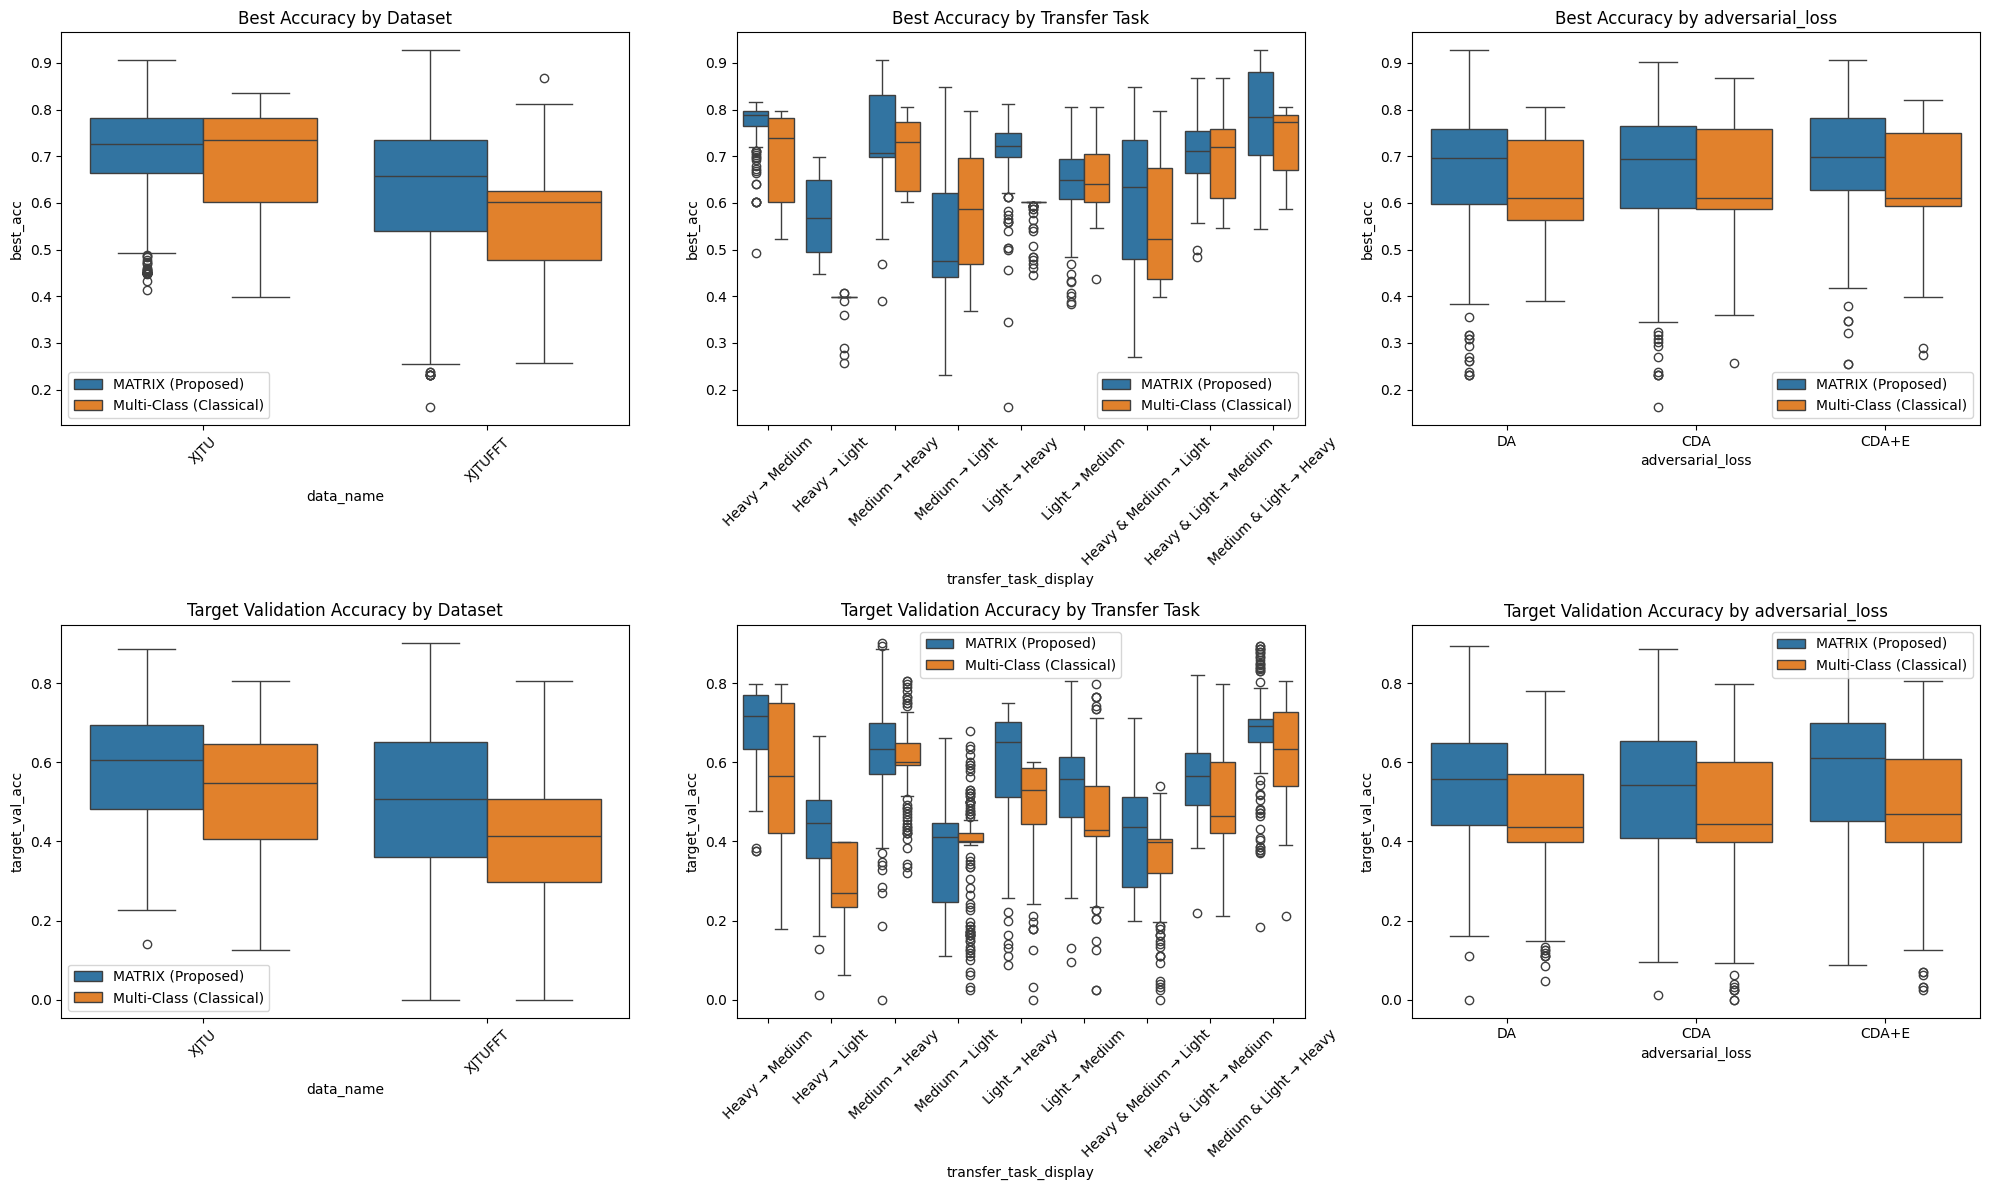

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot for data_name
sns.boxplot(data=df_combined, x='data_name', y='best_acc', ax=axes[0,0], hue='task_type_display')
sns.boxplot(data=df_combined, x='data_name', y='target_val_acc', ax=axes[1,0], hue='task_type_display')
axes[0,0].set_title('Best Accuracy by Dataset')
axes[1,0].set_title('Target Validation Accuracy by Dataset')
axes[0,0].tick_params(axis='x', rotation=45)
axes[1,0].tick_params(axis='x', rotation=45)

# Plot for distance_loss
sns.boxplot(data=df_combined, x='transfer_task_display', y='best_acc', ax=axes[0,1], hue='task_type_display')
sns.boxplot(data=df_combined, x='transfer_task_display', y='target_val_acc', ax=axes[1,1], hue='task_type_display')
axes[0,1].set_title('Best Accuracy by Transfer Task')
axes[1,1].set_title('Target Validation Accuracy by Transfer Task')
axes[0,1].tick_params(axis='x', rotation=45)
axes[1,1].tick_params(axis='x', rotation=45)

# Plot for opt 
sns.boxplot(data=df_combined, x='adversarial_loss', y='best_acc', ax=axes[0,2], hue='task_type_display')
sns.boxplot(data=df_combined, x='adversarial_loss', y='target_val_acc', ax=axes[1,2], hue='task_type_display')
axes[0,2].set_title('Best Accuracy by adversarial_loss')
axes[1,2].set_title('Target Validation Accuracy by adversarial_loss')

# 对其他子图也做相同处理
axes[0,0].legend(title='')
axes[0,1].legend(title='')
axes[0,2].legend(title='')
axes[1,0].legend(title='')
axes[1,1].legend(title='')
axes[1,2].legend(title='')

plt.tight_layout()
plt.savefig('performance_comparison.svg', bbox_inches='tight')

In [65]:
# Find rows where best_acc or target_val_acc > 0.8
high_performance_rows = df_combined[(df_combined['best_acc'] > 0.6) | (df_combined['target_val_acc'] > 0.6)]

# Display relevant columns
print("High performance configurations (accuracy > 0.8):")
high_performance_rows[['model_name', 'data_name', 'task_type', 'transfer_task', 'best_acc', 'target_val_acc', 
                           'adversarial_loss', 'opt', 'lr_scheduler']].sort_values(by=['best_acc', 'target_val_acc'], 
                                                                                 ascending=False)


High performance configurations (accuracy > 0.8):


,model_name,data_name,task_type,transfer_task,best_acc,target_val_acc,adversarial_loss,opt,lr_scheduler
797,resnet_features_1d,XJTUFFT,multi_label,"[[1, 2], [0]]",0.9271,0.7461,DA,adam,step
767,resnet_features_1d,XJTUFFT,multi_label,"[[1, 2], [0]]",0.9206,0.8945,DA,adam,step
769,resnet_features_1d,XJTUFFT,multi_label,"[[1, 2], [0]]",0.9115,0.8789,DA,adam,stepLR
402,resnet_features_1d,XJTU,multi_label,"[[1, 2], [0]]",0.9062,0.8594,CDA+E,adam,step
103,resnet_features_1d,XJTU,multi_label,"[[1], [0]]",0.9062,0.7383,CDA+E,adam,exp
...,...,...,...,...,...,...,...,...,...
2266,resnet_features_1d,XJTUFFT,multi_class,"[[2], [1]]",0.6016,0.1484,DA,sgd,exp
1809,resnet_features_1d,XJTU,multi_class,"[[2], [0]]",0.6016,0.1250,CDA,adam,stepLR
2260,resnet_features_1d,XJTUFFT,multi_class,"[[2], [1]]",0.6016,0.0234,CDA+E,sgd,step
2271,resnet_features_1d,XJTUFFT,multi_class,"[[2], [1]]",0.6016,0.0234,CDA,sgd,exp


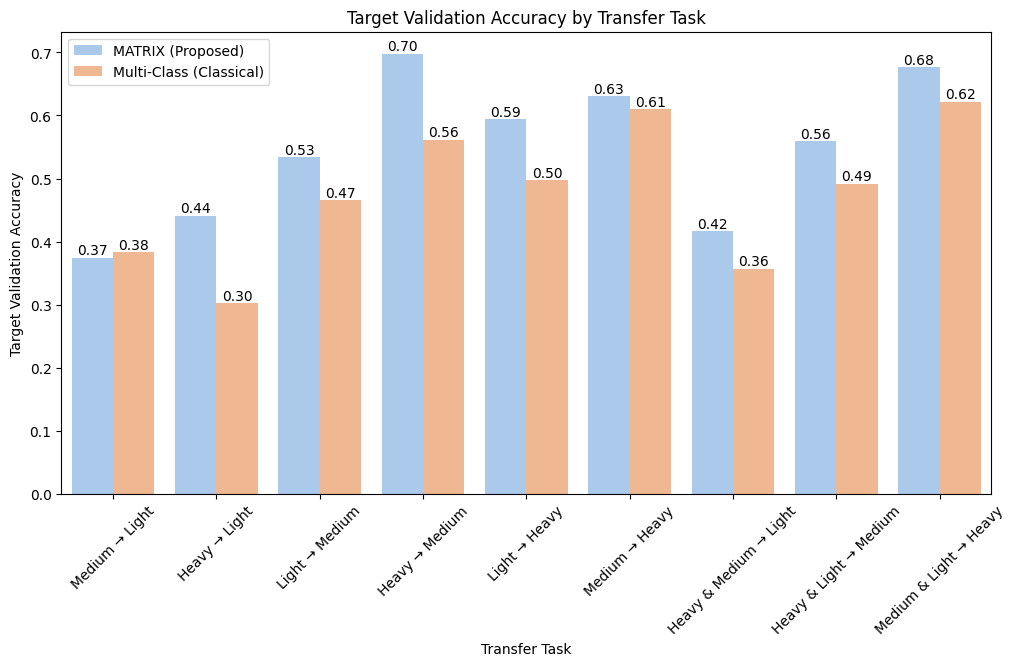

In [68]:
def add_value_labels(ax, spacing=0):
    """在柱状图的每个bar上添加数值标签
    
    Parameters:
        ax : matplotlib.axes.Axes
            The axes object containing the bars
        spacing : int
            The vertical spacing between value labels and bars
    """
    for rect in ax.patches:
        # 获取高度和y位置
        height = rect.get_height()
        # 添加文本标签
        if height > 0:
            ax.text(
                rect.get_x() + rect.get_width()/2.,  # x位置（水平居中）
                height + spacing/100.,                # y位置（略高于柱顶）
                f'{height:.2f}',                     # 显示的文本（保留3位小数）
                ha='center',                         # 水平居中对齐
                va='bottom',                         # 垂直底部对齐
                fontsize=10                           # 字体大小
            )

transfer_task_order = [
    # 单源到单目标的迁移 (按照从重载到轻载的顺序)
    'Medium → Light',    
    'Heavy → Light',     
    'Light → Medium',    
    'Heavy → Medium',    
    'Light → Heavy',     
    'Medium → Heavy',    
    # 多源到单目标的迁移 (放在最后)
    'Heavy & Medium → Light',    
    'Heavy & Light → Medium',    
    'Medium & Light → Heavy'    
]


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_combined, 
            x='transfer_task_display', 
            y='target_val_acc', 
            hue='task_type_display', 
            palette='pastel',
            order=transfer_task_order,
            errorbar=None)
add_value_labels(ax)
ax.set_title('Target Validation Accuracy by Transfer Task')
ax.tick_params(axis='x', rotation=45)
plt.xlabel('Transfer Task')
plt.ylabel('Target Validation Accuracy')

# Add individual points
# sns.stripplot(data=df_combined, x='transfer_task_display', y='target_val_acc', hue='task_type_display', 
#               palette='bright',
#               dodge=True, alpha=0.3, jitter=0.2, size=4, )
plt.legend(title='')

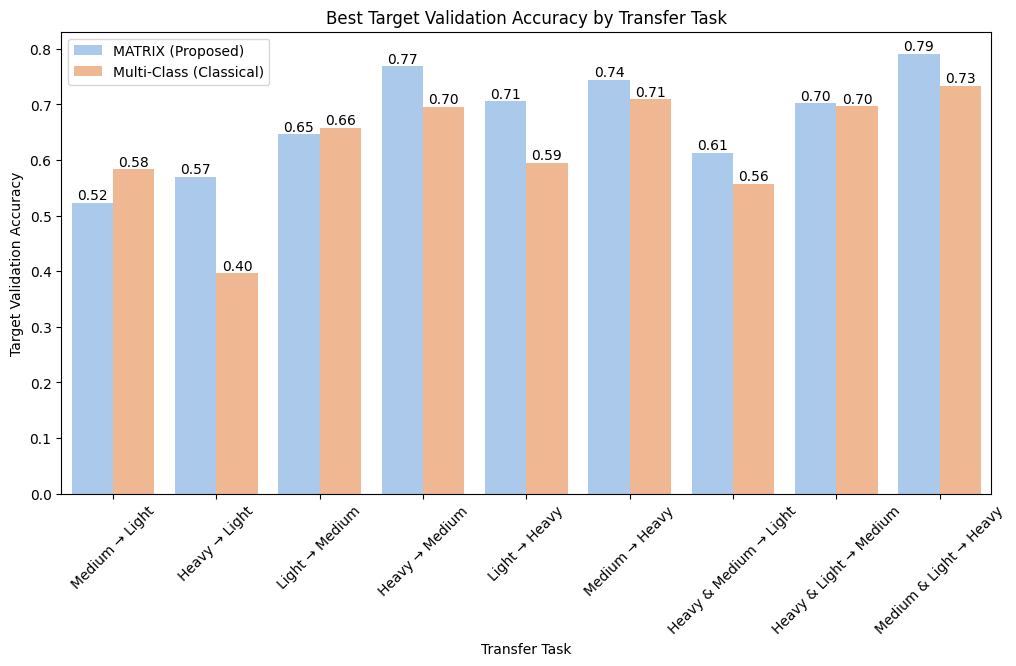

In [70]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_combined, 
            x='transfer_task_display', 
            y='best_acc', 
            hue='task_type_display', 
            palette='pastel',
            order=transfer_task_order,
            errorbar=None)
add_value_labels(ax)

plt.xlabel('Transfer Task')
plt.ylabel('Target Validation Accuracy')
ax.set_title('Best Target Validation Accuracy by Transfer Task')
ax.tick_params(axis='x', rotation=45)

plt.legend(title='')

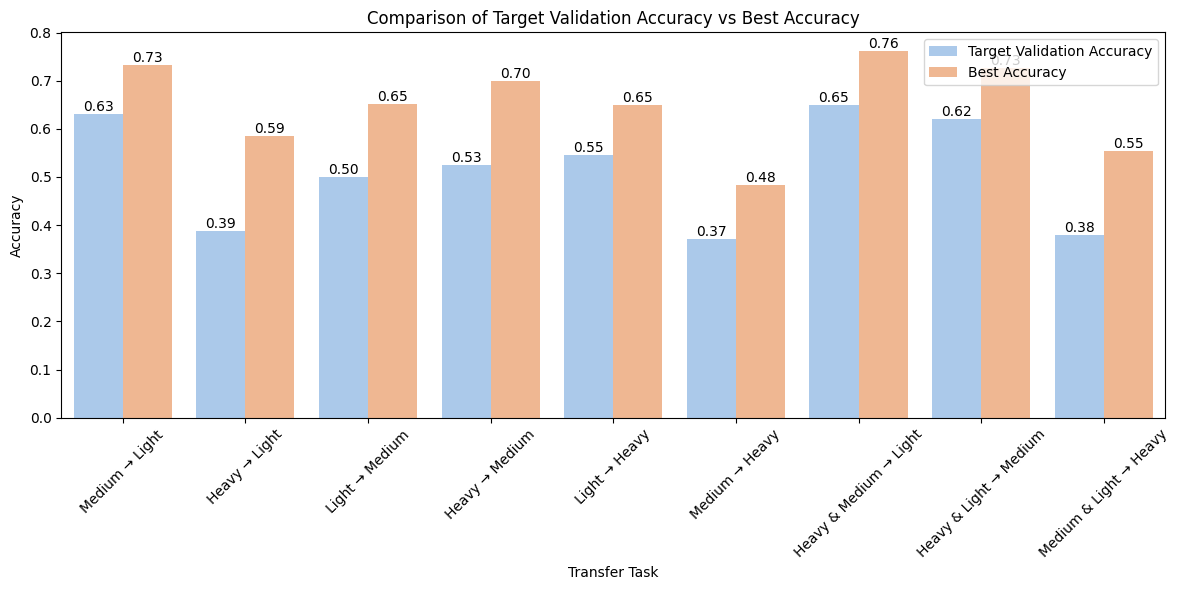

In [74]:
# Melt the dataframe to create long format data
df_melted = pd.DataFrame({
    'Transfer Task': df_combined['transfer_task_display'].unique(),
    'Target Validation Accuracy': df_combined.groupby('transfer_task_display')['target_val_acc'].mean(),
    'Best Accuracy': df_combined.groupby('transfer_task_display')['best_acc'].mean()
}).melt(id_vars=['Transfer Task'], var_name='Metric', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, 
                x='Transfer Task', 
                y='Accuracy', 
                hue='Metric',
                palette='pastel',
                order=transfer_task_order)

# Add value labels on top of bars
add_value_labels(ax)

# Customize the plot
plt.title('Comparison of Target Validation Accuracy vs Best Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Transfer Task')
plt.ylabel('Accuracy')
plt.legend(title='')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [17]:
# 选择要分析的参数列
params = ["data_name", 'adversarial_loss', 'opt', 'lr_scheduler', 'distance_metric']

# 计算每种参数组合下的平均性能并排序
performance_by_params = df_combined.groupby(params)['target_val_acc'].agg([
    'mean',
    'std',
    'count'
]).round(4).sort_values('mean', ascending=False)

print("Top 10 parameter combinations by average target validation accuracy:")
print(performance_by_params.head(10))

Top 10 parameter combinations by average target validation accuracy:
                                                                mean     std  \
data_name adversarial_loss opt  lr_scheduler distance_metric                   
XJTU      CDA+E            adam step         False            0.6301  0.1381   
          CDA              adam step         False            0.6286  0.1259   
          CDA+E            adam stepLR       False            0.6213  0.1250   
                                exp          False            0.6137  0.1350   
          DA               adam stepLR       False            0.6000  0.1130   
          CDA              adam stepLR       False            0.5996  0.1390   
                                exp          False            0.5951  0.1350   
          DA               adam step         False            0.5947  0.1080   
                                exp          False            0.5928  0.1148   
          CDA+E            sgd  step         False 


Best data_name:
data_name
XJTU       0.566941
XJTUFFT    0.457099
Name: target_val_acc, dtype: float64

Best adversarial_loss:
adversarial_loss
CDA+E    0.539175
CDA      0.499432
DA       0.497452
Name: target_val_acc, dtype: float64

Best opt:
opt
adam    0.517097
sgd     0.504405
Name: target_val_acc, dtype: float64

Best lr_scheduler:
lr_scheduler
stepLR    0.516059
step      0.513685
exp       0.508335
Name: target_val_acc, dtype: float64

Best distance_metric:
distance_metric
False    0.547295
Name: target_val_acc, dtype: float64


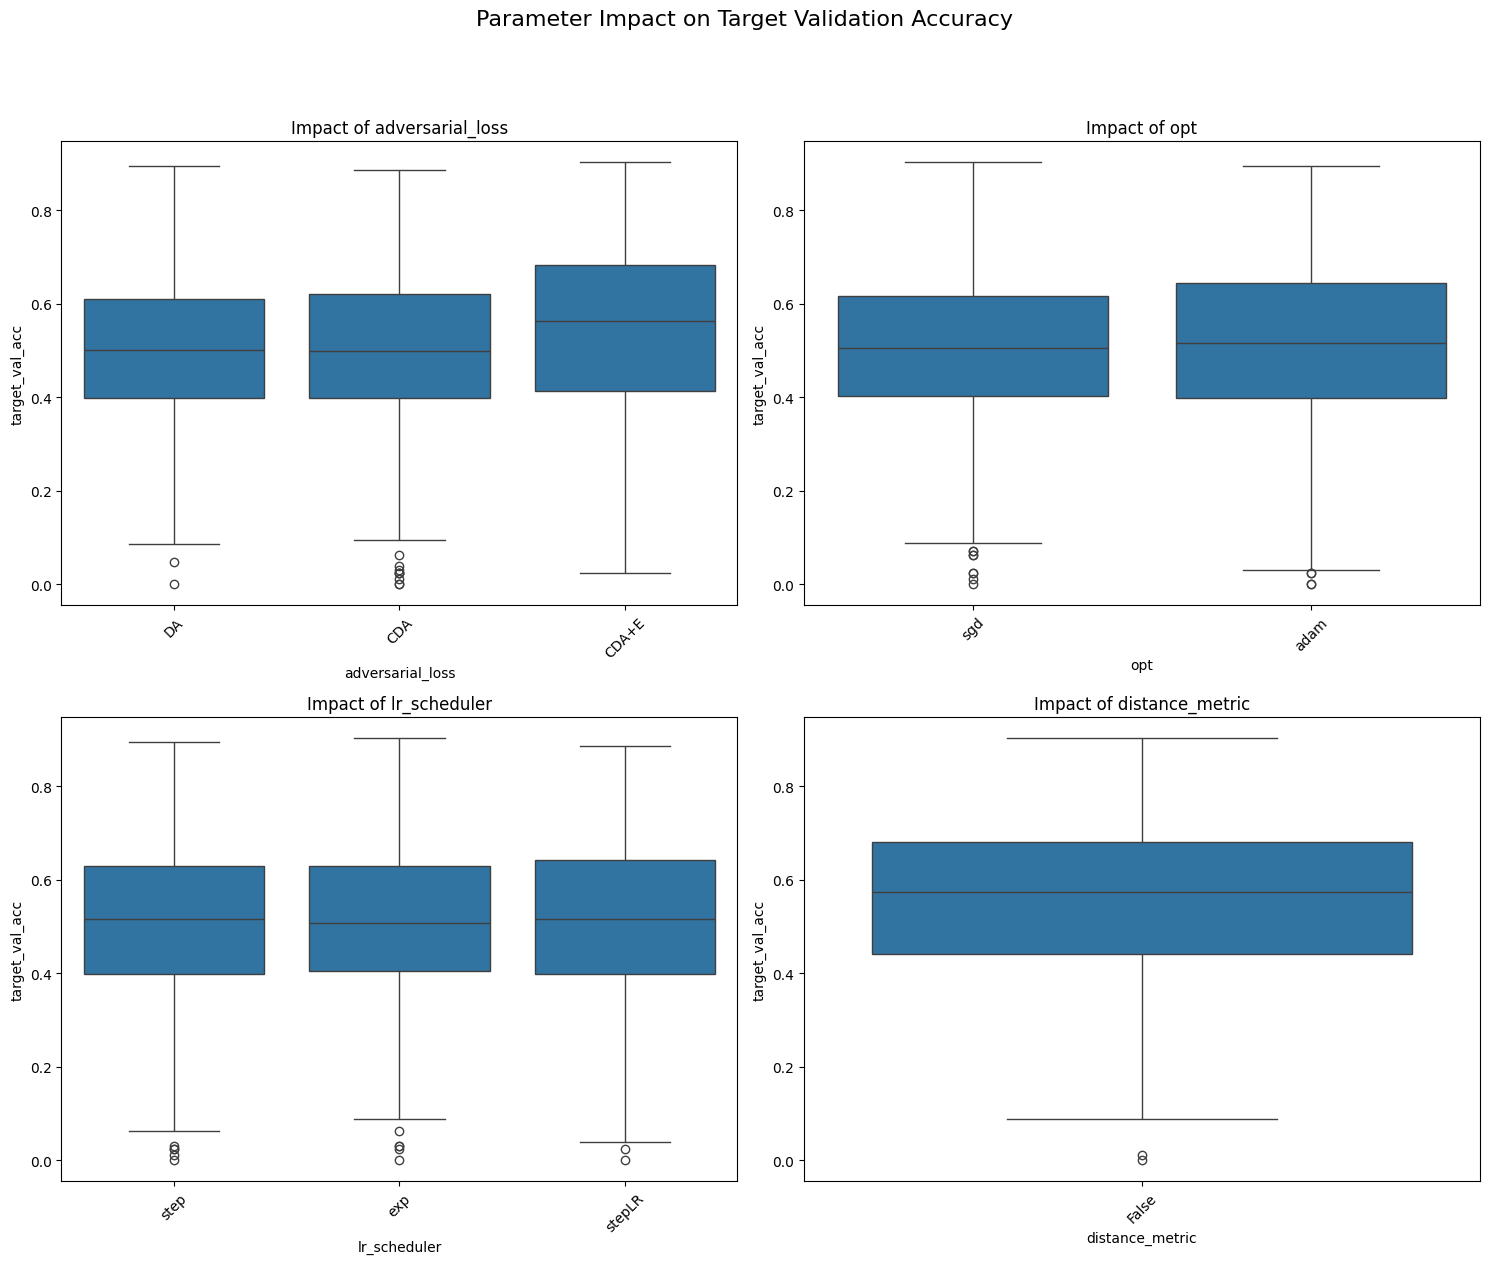

In [18]:
# 创建一个图表来可视化不同参数的影响
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Parameter Impact on Target Validation Accuracy', fontsize=16, y=1.05)

# 分别分析每个参数的影响
params_to_plot = {
    (0,0): 'adversarial_loss',
    (0,1): 'opt',
    (1,0): 'lr_scheduler',
    (1,1): 'distance_metric'
}

for (i,j), param in params_to_plot.items():
    sns.boxplot(data=df_combined, x=param, y='target_val_acc', ax=axes[i,j])
    axes[i,j].set_title(f'Impact of {param}')
    axes[i,j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('parameter_impact.svg', bbox_inches='tight', dpi=300)

# 打印每个参数的最优选择
for param in params:
    best_param = df_combined.groupby(param)['target_val_acc'].mean().sort_values(ascending=False)
    print(f"\nBest {param}:")
    print(best_param.head())


Summary Statistics:
                 mean     std  count
transfer_task                       
[[0, 1], [2]]  0.4878  0.1066     12
[[0, 2], [1]]  0.6207  0.1073     12
[[0], [1]]     0.7246  0.0888     12
[[0], [2]]     0.4786  0.1082     12
[[1, 2], [0]]  0.7721  0.0716     12
[[1], [0]]     0.6937  0.1060     12
[[1], [2]]     0.4388  0.0726     12
[[2], [0]]     0.6358  0.1112     12
[[2], [1]]     0.5772  0.1064     12


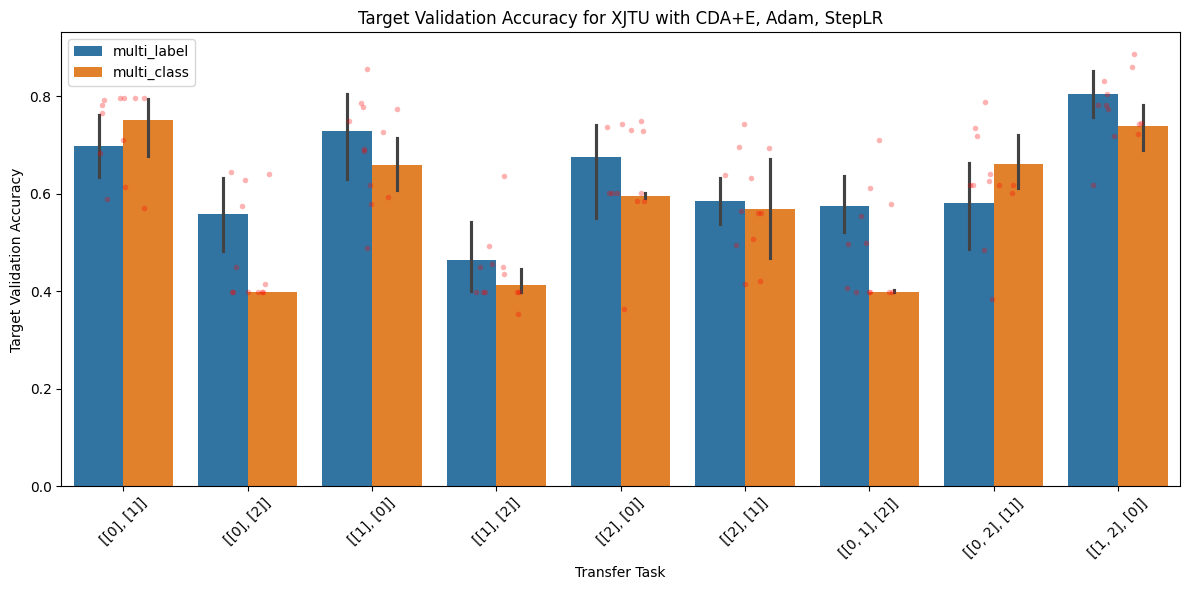

In [ ]:
# Filter for specific combination
filtered_df = df_combined[
    (df_combined['data_name'] == 'XJTU') & 
    (df_combined['adversarial_loss'] == 'CDA+E') & 
    (df_combined['opt'] == 'adam') & 
    (df_combined['lr_scheduler'] == 'step')
]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df, x='transfer_task', y='target_val_acc', hue='task_type_display')
plt.title('Target Validation Accuracy for XJTU with CDA+E, Adam, StepLR')
plt.xticks(rotation=45)
plt.xlabel('Transfer Task')
plt.ylabel('Target Validation Accuracy')
plt.legend(title='')

sns.stripplot(data=filtered_df, x='transfer_task', y='target_val_acc', 
              color='red', alpha=0.3, jitter=0.2, size=4)

print("\nSummary Statistics:")
summary_stats = filtered_df.groupby('transfer_task')['target_val_acc'].agg(['mean', 'std', 'count']).round(4)
print(summary_stats)

plt.tight_layout()